In [1]:
!pip install python-graphblas[default]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 13.7 MB/s eta 0:00:00


In [2]:
import graphblas as gb
gb.init("suitesparse", blocking=False)
from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder, Vector
from graphblas.io import mmread
import numpy as np
import random
import math

## Обязательные задачи

1. Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Levels) в ширину из нескольких заданных стартовых вершин.
 <br> $\cdot$ Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
 <br> $\cdot$    Функция возвращает массив пар: стартовая вершина, и массив (levels), где для каждой вершины указано, на каком уровне она достижима из этой стартовой. Стартовая вершина достижима на нулевом уровне, если вершина не достижима, то значение соответствующей ячейки сделайте равной -1.

2. Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Parents) в ширину из нескольких заданных стартовых вершин.
 <br> $\cdot$  Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
 <br> $\cdot$ Функция возвращает массив пар: стартовая вершина, и массив (parents), где для каждой вершины графа указано, из какой вершины мы пришли в эту по кратчайшему пути из стартовой вершины. При этом для самой стартовой вершины такое значение взять равное -1, а для недостижимых вершин взять равное -2. При наличии нескольких возможных значений в массивах parents брать наименьшее.

## Реализация MSBFS-Levels

In [ ]:
# Порядок работы функции:
# переменные n и m содержат соответственно общее количество вершин в анализируемом графе и количество стартовых вершин.
# целочисленная матрица result включает m строк и n столбцов, она хранит результаты для стартовых вершин.
# булева матрица f хранит векторы фронтов (frontier)
# данная матрица f изначально заполняется значением True по главной диагонали.
# переменная succ является вектором булевых значений размерности m.
# Запускается бесконечный цикл while (предусматривающий две причины остановки).
# Для фронта задаётся уровень глубины (level), увеличивающтйся на каждом цаге цикла while.
# Маскируется очередной фронт матрицы.
# далее в цикле for производится заполнение вектора перехода к доступным вершинам для каждой из стартовых вершин.
# завершение цикла while производится по двум основаниям:
#     если хотя бы один элемент True, дальше искать не имеет смысла
#     если для стартовой вершины на очередной итерации нет доступных вершин;
# далее в словарь final производится "упаковка" результата.

def level_BFS(A, massiv):
  n = A.nrows
  m = len(massiv)
  result = Matrix(dtypes.INT32, m, n)
  f = Matrix(bool, m, n)
  for i in range(m):
    f[i, massiv[i]] << True
  succ = Vector(bool, m)
  level = 0
  while True:
    result(mask=f.V) << level
    f(~result.S, replace=True) << f.mxm(A, semiring.lor_land)
    for i in range(m):
      succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False)
    for i in range(m):
      if succ[i]:
        break
    if not succ[i]:
      break
    level += 1
  final = dict()
  for i in range(0, m):
    values = []
    for j in range(0, n):
      if result[i, j].value is None:
        values.append(-1)
      else:
        values.append(result[i, j].value)
    final[massiv[i]] = values
  return final

## Реализация MSBFS-Parents

In [ ]:
# Порядок работы функции:
# переменные n и m содержат соответственно общее количество вершин в анализируемом графе и количество стартовых вершин.
# целочисленная матрица result включает m строк и n столбцов
# Данная матрица запоняется номерами вершин от 0 до количества вершин -1.
# Создаются матрицы "родителей" (parents) и матрица фронта (wavefront)
# В цикле for заполняются матрицы родителей и фронта.
# В последующем цикле while выполняется обход графа.
# далее в словарь final производится "упаковка" результата.

def parent_BFS(A, massiv):
  n = A.nrows
  m = len(massiv)
  index_ramp = Matrix(dtypes.UINT64, m, n)
  for i in range(m):
    for j in range(n):
      index_ramp[i,j] << j
  parents = Matrix(dtypes.UINT64, m, n)
  wavefront = Matrix(dtypes.UINT64, m, n)
  for i in range(m):
    parents[i,massiv[i]] << massiv[i]
    wavefront[i, massiv[i]] << 1
  while wavefront.nvals > 0:
    wavefront << index_ramp.ewise_mult(wavefront, binary.first)
    wavefront (~parents.S, replace=True) << wavefront.mxm(A, semiring.min_first)
    parents(binary.plus) << wavefront
  final = dict()
  for i in range(m):
    values = []
    for j in range(n):
      if parents[i, j].value is None:
        values.append(-2)
      elif j == massiv[i]:
        values.append(-1)
      else:
        values.append(parents[i,j].value)
    final[massiv[i]] = values
  return final

## Тестирование функций

### Для тестирования функций используем графы из первой лабораторной работы, сделав их ориентированные и неориентированные варианты

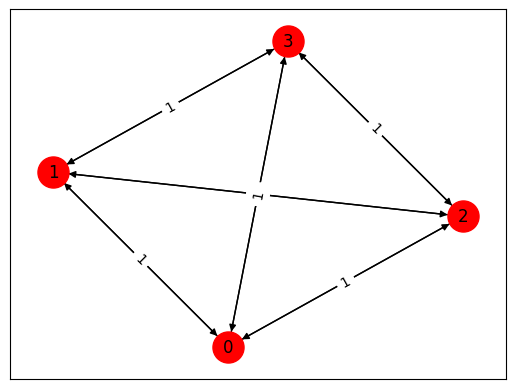

In [ ]:
# Построим полносвязный планарный граф с четырьмя вершинами
# Он должен быть как треугольник с одной вершиной внутри трегульника (чтобы быть планарным)
# К сожалению программа отрисовывает его в непланарном виде

M1 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 2, 3, 3, 1, 3, 0],
  [1, 0, 2, 1, 0, 2, 3, 2, 1, 3, 0, 3],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=4, ncols=4,)

gb.viz.draw(M1)

In [ ]:
start = [0, 1]
print('level_BFS:', level_BFS(M1, start))
print('parent_BFS:', parent_BFS(M1, start))

level_BFS: {0: [0, 1, 1, 1], 1: [1, 0, 1, 1]}
parent_BFS: {0: [-1, 0, 0, 0], 1: [1, -1, 1, 1]}


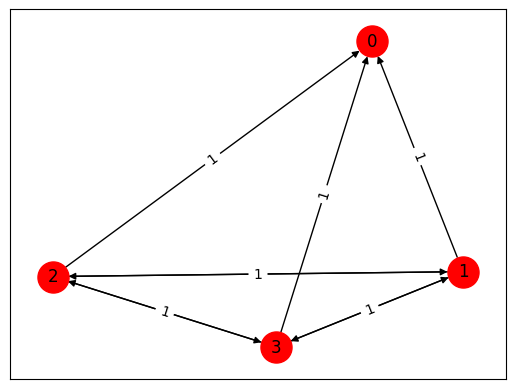

In [ ]:
# Изменим предыдущий граф, удалив исходящие пути из вершины 0

M1_2 = gb.Matrix.from_coo(
  [1, 1, 2, 2, 2, 3, 3, 1, 3],
  [0, 2, 1, 0, 3, 2, 1, 3, 0],
  [1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=4, ncols=4,)

gb.viz.draw(M1_2)

In [ ]:
start = [0]
print('level_BFS:', level_BFS(M1_2, start))
print('parent_BFS:', parent_BFS(M1_2, start))

level_BFS: {0: [0, -1, -1, -1]}
parent_BFS: {0: [-1, -2, -2, -2]}


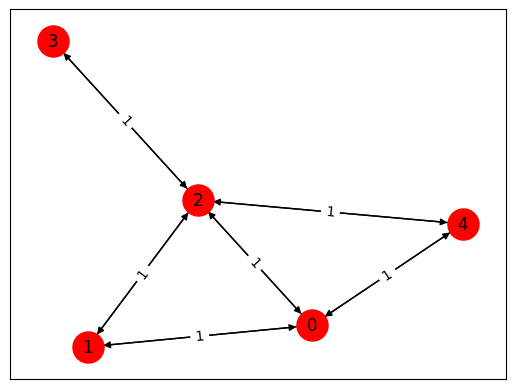

In [ ]:
# Граф - воздушный змей

M2 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 2, 3, 4, 0, 4, 2],
  [1, 0, 2, 1, 0, 2, 3, 2, 0, 4, 2, 4],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=5, ncols=5,)

gb.viz.draw(M2)

In [ ]:
# стартовыми сделаем вершины 0 и 3
start = [0, 3]
print('level_BFS:', level_BFS(M2, start))
print('parent_BFS:', parent_BFS(M2, start))

level_BFS: {0: [0, 1, 1, 2, 1], 3: [2, 2, 1, 0, 2]}
parent_BFS: {0: [-1, 0, 0, 2, 0], 3: [2, 2, 3, -1, 2]}


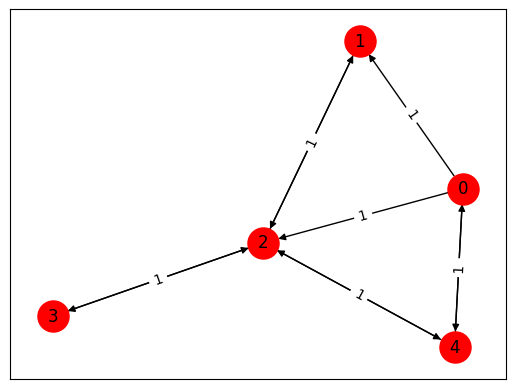

In [ ]:
# Граф - воздушный змей
# уберём связь 0 -> 1 и связь 0 -> 2

M2_2 = gb.Matrix.from_coo(
  [0, 1, 2, 0, 2, 3, 4, 0, 4, 2],
  [1, 2, 1, 2, 3, 2, 0, 4, 2, 4],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=5, ncols=5,)

gb.viz.draw(M2_2)

In [ ]:
# стартовыми сделаем вершины 0 и 3
start = [0, 3]
print('level_BFS:', level_BFS(M2_2, start))
print('parent_BFS:', parent_BFS(M2_2, start))

level_BFS: {0: [0, 1, 1, 2, 1], 3: [3, 2, 1, 0, 2]}
parent_BFS: {0: [-1, 0, 0, 2, 0], 3: [4, 2, 3, -1, 2]}


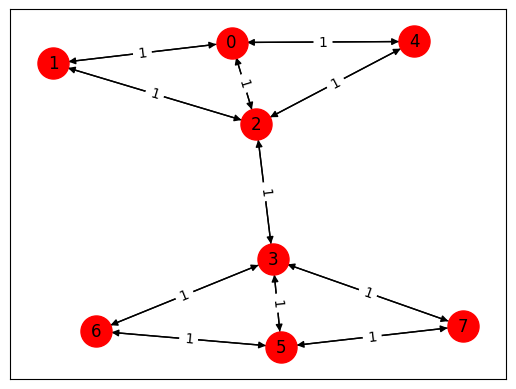

In [ ]:
# Граф - два воздушных змея, связанных верёвочкой

M3 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 2, 3, 4, 0, 4, 2, 3, 5, 3, 6, 5, 6, 3, 7, 5, 7],
  [1, 0, 2, 1, 0, 2, 3, 2, 0, 4, 2, 4, 5, 3, 6, 3, 6, 5, 7, 3, 7, 5],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=8, ncols=8,)

gb.viz.draw(M3)

In [ ]:
# стартовыми сделаем вершины 0, 2, 7
start = [0, 2, 7]
print('level_BFS:', level_BFS(M3, start))
print('parent_BFS:', parent_BFS(M3, start))

level_BFS: {0: [0, 1, 1, 2, 1, 3, 3, 3], 2: [1, 1, 0, 1, 1, 2, 2, 2], 7: [3, 3, 2, 1, 3, 1, 2, 0]}
parent_BFS: {0: [-1, 0, 0, 2, 0, 3, 3, 3], 2: [2, 2, -1, 2, 2, 3, 3, 3], 7: [2, 2, 3, 7, 2, 7, 3, -1]}


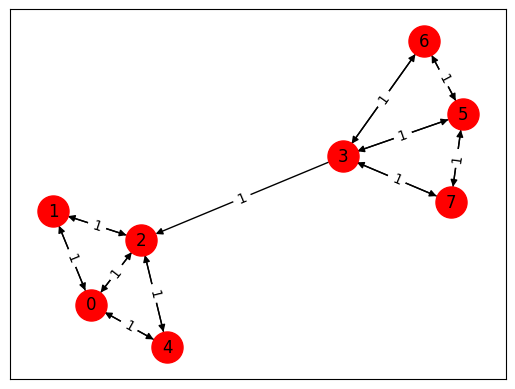

In [ ]:
# Граф - два воздушных змея, связанных верёвочкой
# удалим связь 2 -> 3

M3_2 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 3, 4, 0, 4, 2, 3, 5, 3, 6, 5, 6, 3, 7, 5, 7],
  [1, 0, 2, 1, 0, 2, 2, 0, 4, 2, 4, 5, 3, 6, 3, 6, 5, 7, 3, 7, 5],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=8, ncols=8,)

gb.viz.draw(M3_2)

In [ ]:
# стартовыми сделаем вершины 0, 2, 7
start = [0, 2, 7]
print('level_BFS:', level_BFS(M3_2, start))
print('parent_BFS:', parent_BFS(M3_2, start))

level_BFS: {0: [0, 1, 1, -1, 1, -1, -1, -1], 2: [1, 1, 0, -1, 1, -1, -1, -1], 7: [3, 3, 2, 1, 3, 1, 2, 0]}
parent_BFS: {0: [-1, 0, 0, -2, 0, -2, -2, -2], 2: [2, 2, -1, -2, 2, -2, -2, -2], 7: [2, 2, 3, 7, 2, 7, 3, -1]}


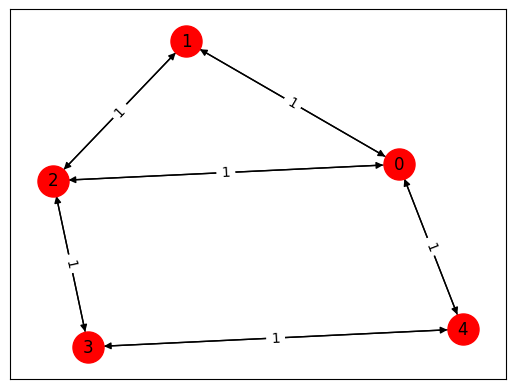

In [ ]:
# Граф "домик"

M4 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 3, 4, 2, 3, 4, 0, 0, 2],
  [1, 0, 2, 1, 4, 3, 3, 2, 0, 4, 2, 0],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=5, ncols=5,)

gb.viz.draw(M4)

In [ ]:
# стартовыми сделаем вершины 1, 4
start = [1, 4]
print('level_BFS:', level_BFS(M4, start))
print('parent_BFS:', parent_BFS(M4, start))

level_BFS: {1: [1, 0, 1, 2, 2], 4: [1, 2, 2, 1, 0]}
parent_BFS: {1: [1, -1, 1, 2, 0], 4: [4, 0, 0, 4, -1]}


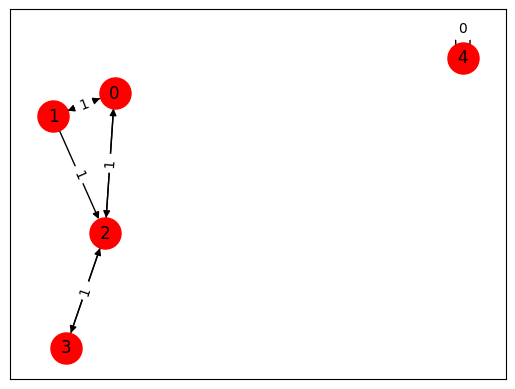

In [ ]:
# Граф "домик"
# сделаем вершину 4 изолированной
# уберём связь 1 -> 2

M4_2 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 3, 0, 2, 4],
  [1, 0, 2, 3, 2, 2, 0, 4],
  [1, 1, 1, 1, 1, 1, 1, 0],
  nrows=5, ncols=5,)

gb.viz.draw(M4_2)

In [ ]:
# стартовыми сделаем вершины 1, 4
start = [1, 4]
print('level_BFS:', level_BFS(M4_2, start))
print('parent_BFS:', parent_BFS(M4_2, start))

level_BFS: {1: [1, 0, 1, 2, -1], 4: [-1, -1, -1, -1, 0]}
parent_BFS: {1: [1, -1, 1, 2, -2], 4: [-2, -2, -2, -2, -1]}


Вывод: функции работают корректно.

# Дополнительные задачи

Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин.

### Большие графы с сайта SuiteSparse Matrix Collection

In [ ]:
# читаем 5 графов
graph1 = mmread('/content/bcsstk22.mtx')
graph2 = mmread('/content/can_229.mtx')
graph3 = mmread('/content/dwt_512.mtx')
graph4 = mmread('/content/lshp1009.mtx')
graph5 = mmread('/content/jagmesh3.mtx')

# массив графов
graphs = [graph1, graph2, graph3, graph4, graph5]
# список имён графов
graphs_names = ['bcsstk22', 'can_229', 'dwt_512', 'lshp1009', 'jagmesh3']

In [ ]:
# функция подсчета времени выполнения реализованных функций
def alg_time(A, a):
  print('level_BFS:')
  %timeit level_BFS(A, a)
  print('parent_BFS:')
  %timeit parent_BFS(A, a)

In [ ]:
# функция генерации массива стартовых вершин, где n - количество вершин в графе и p - доля генерируемых стартовых вершин
def vertex_generate(n, p):
  points = range(n)
  points_arr = random.sample(points, round(n * p))
  return np.array(points_arr)


gen_vertex = [0.01, 0.05, 0.1]
cnt = 0
for k in graphs:
  print('Название графа:', graphs_names[cnt], 'Количество вершин:', k.nrows, 'Количество ребер:', k.nvals)
  cnt += 1
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time(k, vertex_generate(k.nrows, p)))
  print()

Название графа: bcsstk22 Количество вершин: 138 Количество ребер: 696
Количество стартовых вершин: 1
level_BFS:
25.6 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS:
18.7 ms ± 4.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 7
level_BFS:
86.4 ms ± 816 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS:
117 ms ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 14
level_BFS:
187 ms ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS:
218 ms ± 33.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None

Название графа: can_229 Количество вершин: 229 Количество ребер: 1777
Количество стартовых вершин: 2
level_BFS:
54.9 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS:
55.1 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 11
level_BFS:
236 ms ± 7.65 m

##Случайно сгенерированные графы

Для генерации используется функция из первой лаборатороной работы

In [ ]:
# Функция принимает два параметра: количество вершин и разреженность.
# Количество рёбер в случайно генерируемом графе определяется выполнением неравенства,
# состоящего в том, что отношение количества рёбер к максимально возможному количеству
# рёбер при данном количестве вершин не должно превысить значение параметра разреженности
#
# Максимально возможное количество рёбер определяется как число сочетаний (биномиальный
# коэффициент) из количества вершин по 2.
#

def random_graph(n, ro):
    # генерим нужное количество уникальных пар
    limit = math.factorial(n) / (2 * math.factorial(n - 2))
    arr_pairs = []
    while len(arr_pairs) / limit < ro:
        a = random.randint(0, n-1)
        b = random.randint(0, n-1)
        if a == b: continue
        else:
            tmp = [a, b]
            tmp_2 = [b, a]
            if tmp not in arr_pairs and tmp_2 not in arr_pairs:
                arr_pairs.append(tmp)
    #print(arr_pairs)

    # создаём два списка (с обратными парами, чтоб убрать направленность графа)
    cols = []
    rows = []
    for el in arr_pairs:
        cols.append(el[0])
        rows.append(el[1])
        cols.append(el[1])
        rows.append(el[0])

    #print(cols)
    #print(rows)

    vals = [1] * len(cols)
    #print(vals)

    # создаём граф стандартной функцией
    rand_graph = gb.Matrix.from_coo(
    cols, rows, vals, nrows=n, ncols=n)

    return rand_graph

In [ ]:
# генерируем граф со 100 вершинами, коэффициентом разреженности 0.1, и 10% вершин как стартовые
rg_0 = random_graph(100, 0.1)
alg_time(rg_0, vertex_generate(rg_0.nrows, 0.1))

level_BFS:
148 ms ± 93.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS:
117 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# генерируем граф со 1000 вершинами, коэффициентом разреженности 0.1, и 10% вершин как стартовые
rg_1 = random_graph(1000, 0.1)
alg_time(rg_1, vertex_generate(rg_1.nrows, 0.1))

level_BFS:
9.4 s ± 490 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS:
13.1 s ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#  тот же граф, но как стартовые 5% вершин
alg_time(rg_1, vertex_generate(rg_1.nrows, 0.05))

level_BFS:
4.7 s ± 541 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS:
6.49 s ± 318 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#  тот же граф, но как стартовые 20% вершин
alg_time(rg_1, vertex_generate(rg_1.nrows, 0.2))

level_BFS:
18.9 s ± 526 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS:
26 s ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# генерируем граф со 500 вершинами, коэффициентом разреженности 0.1, и 10% вершин как стартовые
rg_2 = random_graph(500, 0.1)
alg_time(rg_2, vertex_generate(rg_2.nrows, 0.1))

level_BFS:
2.43 s ± 452 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS:
3.37 s ± 486 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# генерируем граф со 1000 вершинами, коэффициентом разреженности 0.2, и 10% вершин как стартовые
rg_3 = random_graph(1000, 0.2)
alg_time(rg_3, vertex_generate(rg_3.nrows, 0.1))

level_BFS:
9.37 s ± 507 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
parent_BFS:
13.1 s ± 87.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


###Выводы на основе обработки больших графов с сайта и сгенерированных графов:

<br> 1. При одинаковом количестве вершин в графе и одинаковом количестве стартовых вершин разница в количестве рёбер практически не оказывает влияния на время работы функций.
<br> 2. Изменение количества стартовых вершин линейно влияет на время работы функций.
<br> 3. Изменение (увеличение) количества вершин ведёт к примерно квадратичному увеличению времени работы функций.

#Второе дополнительное задание

##Использование других полуколец

Добавить реализации описанных алгоритмов с использованием других полуколец (any.pair для levels и any.first для parents). Добавить тесты для проверки корректности. Провести экспериментальное исследование со сравнением этих реализаций с первоначальными на различных графах.

any_pair для level

In [3]:
def level_BFS_any_pair(A, massiv):
  n = A.nrows
  m = len(massiv)
  result = Matrix(dtypes.INT32, m, n)
  f = Matrix(bool, m, n)
  for i in range(m):
    f[i, massiv[i]] << True
  succ = Vector(bool, m)
  level = 0
  while True:
    result(mask=f.V) << level
    f(~result.S, replace=True) << f.mxm(A, semiring.any_pair)
    for i in range(m):
      succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False)
    for i in range(m):
      if succ[i]:
        break
    if not succ[i]:
      break
    level += 1
  final = dict()
  for i in range(0, m):
    values = []
    for j in range(0, n):
      if result[i, j].value is None:
        values.append(-1)
      else:
        values.append(result[i, j].value)
    final[massiv[i]] = values
  return final

any_fyrst для parents

In [4]:
def parent_BFS_any_first(A, massiv):
  n = A.nrows
  m = len(massiv)
  index_ramp = Matrix(dtypes.UINT64, m, n)
  for i in range(m):
    for j in range(n):
      index_ramp[i,j] << j
  parents = Matrix(dtypes.UINT64, m, n)
  wavefront = Matrix(dtypes.UINT64, m, n)
  for i in range(m):
    parents[i,massiv[i]] << massiv[i]
    wavefront[i, massiv[i]] << 1
  while wavefront.nvals > 0:
    wavefront << index_ramp.ewise_mult(wavefront, binary.first)
    wavefront (~parents.S, replace=True) << wavefront.mxm(A, semiring.any_first)
    parents(binary.plus) << wavefront
  final = dict()
  for i in range(m):
    values = []
    for j in range(n):
      if parents[i, j].value is None:
        values.append(-2)
      elif j == massiv[i]:
        values.append(-1)
      else:
        values.append(parents[i,j].value)
    final[massiv[i]] = values
  return final

##Проверка правильности работы двух данных функций

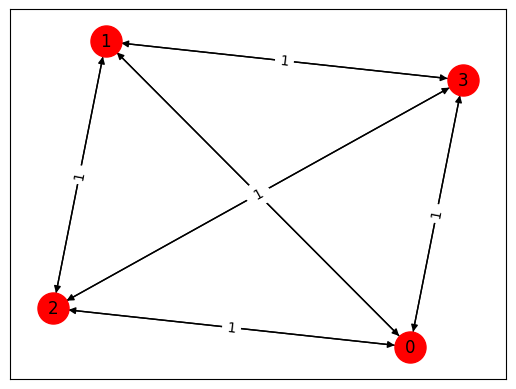

In [ ]:
# Построим полносвязный планарный граф с четырьмя вершинами
# Он должен быть как треугольник с одной вершиной внутри трегульника (чтобы быть планарным)
# К сожалению программа отрисовывает его в непланарном виде

M1 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 2, 3, 3, 1, 3, 0],
  [1, 0, 2, 1, 0, 2, 3, 2, 1, 3, 0, 3],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=4, ncols=4,)

gb.viz.draw(M1)

In [ ]:
start = [0, 1]
print('level_BFS:', level_BFS_any_pair(M1, start))
print('parent_BFS:', parent_BFS_any_first(M1, start))

level_BFS: {0: [0, 1, 1, 1], 1: [1, 0, 1, 1]}
parent_BFS: {0: [-1, 0, 0, 0], 1: [1, -1, 1, 1]}


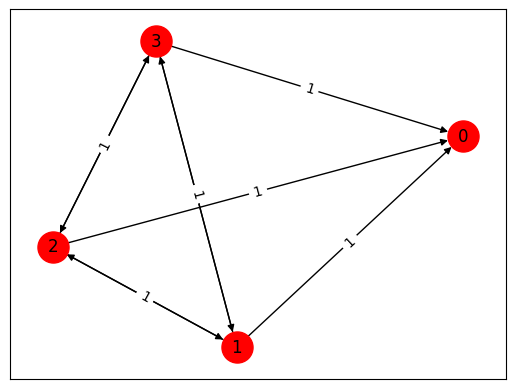

In [ ]:
# Изменим предыдущий граф, удалив исходящие пути из вершины 0

M1_2 = gb.Matrix.from_coo(
  [1, 1, 2, 2, 2, 3, 3, 1, 3],
  [0, 2, 1, 0, 3, 2, 1, 3, 0],
  [1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=4, ncols=4,)

gb.viz.draw(M1_2)

In [ ]:
start = [0, 1]
print('level_BFS:', level_BFS_any_pair(M1_2, start))
print('parent_BFS:', parent_BFS_any_first(M1_2, start))

level_BFS: {0: [0, -1, -1, -1], 1: [1, 0, 1, 1]}
parent_BFS: {0: [-1, -2, -2, -2], 1: [1, -1, 1, 1]}


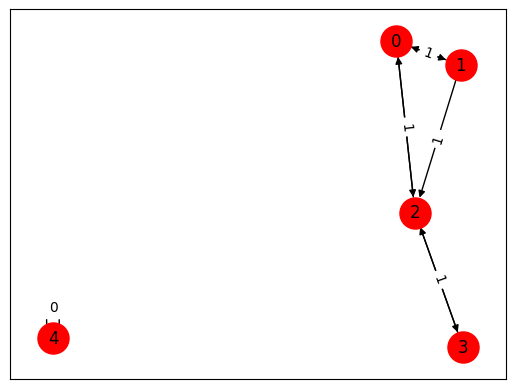

In [ ]:
# Граф "домик"
# сделаем вершину 4 изолированной
# уберём связь 1 -> 2

M4_2 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 3, 0, 2, 4],
  [1, 0, 2, 3, 2, 2, 0, 4],
  [1, 1, 1, 1, 1, 1, 1, 0],
  nrows=5, ncols=5,)

gb.viz.draw(M4_2)

In [ ]:
start = [0, 4]
print('level_BFS:', level_BFS_any_pair(M4_2, start))
print('parent_BFS:', parent_BFS_any_first(M4_2, start))

level_BFS: {0: [0, 1, 1, 2, -1], 4: [-1, -1, -1, -1, 0]}
parent_BFS: {0: [-1, 0, 0, 2, -2], 4: [-2, -2, -2, -2, -1]}


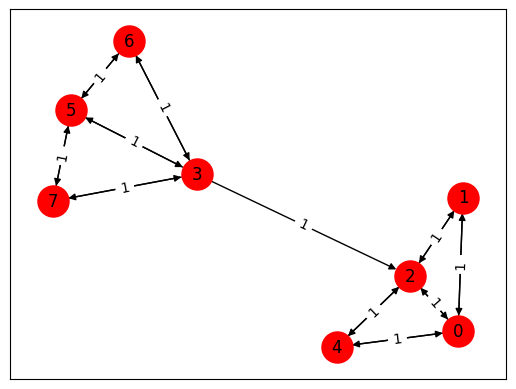

In [ ]:
# Граф - два воздушных змея, связанных верёвочкой
# удалим связь 2 -> 3

M3_2 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 3, 4, 0, 4, 2, 3, 5, 3, 6, 5, 6, 3, 7, 5, 7],
  [1, 0, 2, 1, 0, 2, 2, 0, 4, 2, 4, 5, 3, 6, 3, 6, 5, 7, 3, 7, 5],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=8, ncols=8,)

gb.viz.draw(M3_2)

In [ ]:
start = [0, 4, 5]
print('level_BFS:', level_BFS_any_pair(M3_2, start))
print('parent_BFS:', parent_BFS_any_first(M3_2, start))

level_BFS: {0: [0, 1, 1, -1, 1, -1, -1, -1], 4: [1, 2, 1, -1, 0, -1, -1, -1], 5: [3, 3, 2, 1, 3, 0, 1, 1]}
parent_BFS: {0: [-1, 0, 0, -2, 0, -2, -2, -2], 4: [4, 2, 4, -2, -1, -2, -2, -2], 5: [2, 2, 3, 5, 2, -1, 5, 5]}


Вывод: новые функции работают корректно

##Проверим время работы на реальных графах, используемых ранее

In [7]:
# читаем 5 графов
graph1 = mmread('/content/bcsstk22.mtx')
graph2 = mmread('/content/can_229.mtx')
graph3 = mmread('/content/dwt_512.mtx')
graph4 = mmread('/content/lshp1009.mtx')
graph5 = mmread('/content/jagmesh3.mtx')

# массив графов
graphs = [graph1, graph2, graph3, graph4, graph5]
# список имён графов
graphs_names = ['bcsstk22', 'can_229', 'dwt_512', 'lshp1009', 'jagmesh3']

In [8]:
# функция подсчета времени выполнения реализованных функций
def alg_time(A, a):
  print('level_BFS_any_pair:')
  %timeit level_BFS_any_pair(A, a)
  print('parent_BFS_any_first:')
  %timeit parent_BFS_any_first(A, a)

In [9]:
# функция генерации массива стартовых вершин, где n - количество вершин в графе и p - доля генерируемых стартовых вершин
def vertex_create(n, p):
  points = range(n)
  points_arr = random.sample(points, round(n * p))
  return np.array(points_arr)


gen_vertex = [0.01, 0.05, 0.1]
cnt = 0
for k in graphs:
  print('Название графа:', graphs_names[cnt], 'Количество вершин:', k.nrows, 'Количество ребер:', k.nvals)
  cnt += 1
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time(k, vertex_create(k.nrows, p)))
  print()

Название графа: bcsstk22 Количество вершин: 138 Количество ребер: 696
Количество стартовых вершин: 1
level_BFS_any_pair:
16.6 ms ± 3.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
parent_BFS_any_first:
18.3 ms ± 3.45 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 7
level_BFS_any_pair:
93.8 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS_any_first:
101 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 14
level_BFS_any_pair:
185 ms ± 26.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS_any_first:
260 ms ± 56.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None

Название графа: can_229 Количество вершин: 229 Количество ребер: 1777
Количество стартовых вершин: 2
level_BFS_any_pair:
49.2 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
parent_BFS_any_first:
55.3 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 1

Выводы:
<br> 1. Изменение типа используемых полуколец не оказало существенного влияния на скорость работы алгоритмов (функций).
<br> 2. На больших графах, скачанных с сайта, время работы новых и старых функций примерно равно.
<br> 3. Всё же чаще немного быстрее работают старые функции с полукольцами lor_land и min_first.
<br> 4. Их преимущество невелико и обычно не превышает 10%.